## Remaining Useful Life Prediction of Jet Engines using NASA C-MAPSS Dataset                                                 

Prognostics and Health Management (PHM) plays a vital role in modern industry by predicting the health state of machinery and reducing unexpected failures and downtime. This project uses the **NASA C-MAPSS dataset** to build a machine learning model that can estimate the **Remaining Useful Life (RUL)** of aircraft engines.

The dataset consists of run-to-failure simulated data from a fleet of turbo fan jet engines. Each engine is monitored across multiple operating cycles with **21 different sensor** measurements and **3 operational settings**. The data captures how faults evolve over time, providing a rich base for time series modeling and RUL estimation.

By training on complete run-to-failure sequences and predicting RUL for truncated test sequences, the goal is to help anticipate failures before they occur—enabling predictive maintenance in real-world aerospace systems.

### Why Predicting Remaining Useful Life (RUL) Is Important
* Remaining Useful Life (RUL) estimates play a pivotal role in various domains, including aircraft engines, medical equipment, and power plants.

* Expressed in units of time (such as hours or cycles), RUL informs decision-makers about the remaining operational cycles before equipment failure.

* By subjectively determining end-of-life thresholds based on operational conditions, organizations can optimize maintenance schedules, avoid unscheduled repairs, and enhance safety.

* Adjusting operational characteristics, guided by accurate RUL estimates, prolongs component life and ensures a smooth transition from faulty to fully functional equipment.

* Overall, reliable RUL estimation promises substantial cost savings and operational improvements.

<p align="center">
  <img src="../image/Engine.png" width="400"/>
</p>


<p align="center">
  <img src="../image/simulation.png" />
</p>

### 📊 Data Structure:
* The dataset consists of multiple multivariate time series.

* Each dataset is split into training and test subsets.

* Each time series represents an engine, and the data can be considered as coming from a fleet of engines of the same type.

* Engines start with varying degrees of initial wear and manufacturing variation (unknown to the user).

* This wear and variation are considered normal and not indicative of a fault condition.

* The data includes three operational settings that significantly impact engine performance.

* Sensor noise contaminates the data.


### 🔧 Engine Behavior:
* The engine in question is a turbofan engine. It operates normally at the start of each time series.

* At some point during the series, each engine develops a fault due to High Pressure Compressor (HPC) failure.

* In the training set, the fault grows until system failure.

* In the test set, the time series ends before system failure.


### 🎯 Objective:
* The goal is to predict the remaining operational cycles before failure in the test set.

* Specifically, it aims to predict the number of operational cycles after the last cycle that the engine will continue to operate.

* A vector of true Remaining Useful Life (RUL) values is provided for the test data.

#### 📊 Dataset Structure: 26 Columns
Each row in the dataset represents one engine cycle. The columns are:

🔹 Identification & Operational Settings

1. **unit_number** – Engine ID  
2. **time_in_cycles** – Operational cycle count (cycles)  
3. **operational_setting_1**  
4. **operational_setting_2**  
5. **operational_setting_3**  

🔹 Sensor Measurements

6. **T2** – Total temperature at fan inlet (°R)  
7. **T24** – Total temperature at LPC outlet (°R)  
8. **T30** – Total temperature at HPC outlet (°R)  
9. **T50** – Total temperature at LPT outlet (°R)  
10. **P2** – Pressure at fan inlet (psia)  
11. **P15** – Total pressure in bypass duct (psia)  
12. **P30** – Total pressure at HPC outlet (psia)  
13. **Nf** – Physical fan speed (rpm)  
14. **Nc** – Physical core speed (rpm)  
15. **epr** – Engine pressure ratio  
16. **Ps30** – Static pressure at HPC outlet (psia)  
17. **phi** – Ratio of fuel flow to Ps30 (pps/psi)  
18. **NRf** – Corrected fan speed (rpm)  
19. **NRc** – Corrected core speed (rpm)  
20. **BPR** – Bypass ratio  
21. **farB** – Burner fuel-air ratio  
22. **htBleed** – Bleed enthalpy  
23. **Nf_dmd** – Demanded fan speed (rpm)  
24. **PCNfR_dmd** – Demanded corrected fan speed (rpm)  
25. **W31** – HPT coolant bleed (lbm/s)  
26. **W32** – LPT coolant bleed (lbm/s)  

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


# 1. Load & clean function
def load_data(filepath):
    df = pd.read_csv(filepath, sep='\s+', header=None, engine='python')
    df.dropna(axis=1, inplace=True)
    return df



In [158]:
# 2. File paths
train_files = [
    '../data/train_FD001.txt',
    '../data/train_FD002.txt',
    '../data/train_FD003.txt',
    '../data/train_FD004.txt'
]

test_files = [
    '../data/test_FD001.txt',
    '../data/test_FD002.txt',
    '../data/test_FD003.txt',
    '../data/test_FD004.txt'
]

rul_files = [
    '../data/RUL_FD001.txt',
    '../data/RUL_FD002.txt',
    '../data/RUL_FD003.txt',
    '../data/RUL_FD004.txt'
]

In [159]:
# 3. Initialize holders
train_dfs = []
test_dfs = []
y_tests = []
rul_values = []
engine_id_offset = 0

# 4. Process training files
for f in train_files:
    df = load_data(f)
    df[0] += engine_id_offset  # make engine_id unique across files
    df['RUL'] = df.groupby(0)[1].transform('max') - df[1]  # RUL = max cycle - current cycle
    train_dfs.append(df)
    engine_id_offset = df[0].max() + 1  # update offset for next file

engine_id_offset = 0
# 5. Process test files (same logic as train)
for test_fp, rul_fp in zip(test_files, rul_files):
    # a) load test data
    df = load_data(test_fp)
    
    # b) load per-engine RUL at last cycle
    per_engine_rul = pd.read_csv(rul_fp, header=None)[0].values
    #    per_engine_rul[0] → RUL for engine_id=1, etc.
    
    # c) find each engine’s last observed cycle
    last_cycle = df.groupby(0)[1].max()  # Series indexed by engine_id
    
    # d) compute true total life = last_cycle + per_engine_rul
    true_total = last_cycle + pd.Series(per_engine_rul, index=last_cycle.index)
    
    # e) compute row-wise RUL for every row
    df['RUL'] = df.apply(lambda r: true_total.loc[r[0]] - r[1], axis=1)
    
    # f) build the sequence in engine order: [142,141,…,112] for eng1, then eng2, …
    for eng_id in sorted(last_cycle.index):
        eng_rows = df[df[0] == eng_id].sort_values(1)
        rul_values.extend(eng_rows['RUL'].tolist())
    
    # g) offset engine IDs for global uniqueness (optional)
    df[0] += engine_id_offset
    engine_id_offset = df[0].max() + 1
    
    test_dfs.append(df)


print(rul_values)


[142.0, 141.0, 140.0, 139.0, 138.0, 137.0, 136.0, 135.0, 134.0, 133.0, 132.0, 131.0, 130.0, 129.0, 128.0, 127.0, 126.0, 125.0, 124.0, 123.0, 122.0, 121.0, 120.0, 119.0, 118.0, 117.0, 116.0, 115.0, 114.0, 113.0, 112.0, 146.0, 145.0, 144.0, 143.0, 142.0, 141.0, 140.0, 139.0, 138.0, 137.0, 136.0, 135.0, 134.0, 133.0, 132.0, 131.0, 130.0, 129.0, 128.0, 127.0, 126.0, 125.0, 124.0, 123.0, 122.0, 121.0, 120.0, 119.0, 118.0, 117.0, 116.0, 115.0, 114.0, 113.0, 112.0, 111.0, 110.0, 109.0, 108.0, 107.0, 106.0, 105.0, 104.0, 103.0, 102.0, 101.0, 100.0, 99.0, 98.0, 194.0, 193.0, 192.0, 191.0, 190.0, 189.0, 188.0, 187.0, 186.0, 185.0, 184.0, 183.0, 182.0, 181.0, 180.0, 179.0, 178.0, 177.0, 176.0, 175.0, 174.0, 173.0, 172.0, 171.0, 170.0, 169.0, 168.0, 167.0, 166.0, 165.0, 164.0, 163.0, 162.0, 161.0, 160.0, 159.0, 158.0, 157.0, 156.0, 155.0, 154.0, 153.0, 152.0, 151.0, 150.0, 149.0, 148.0, 147.0, 146.0, 145.0, 144.0, 143.0, 142.0, 141.0, 140.0, 139.0, 138.0, 137.0, 136.0, 135.0, 134.0, 133.0, 132.0, 

In [160]:
# 6. Combine all data
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)


In [161]:
# 7. Define feature columns (exclude engine_id, cycle, and RUL)
sensor_cols = train_df.columns[2:-1]

# 8. Extract features & labels
X_train = train_df[sensor_cols]
y_train = train_df['RUL'].values.ravel()  # flatten to (n,)
X_test = test_df[sensor_cols]
y_test = np.array(rul_values)   # flatten to (n,)



In [162]:
columns = ['setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
X_train.columns=columns
X_test.columns=columns

print(X_train)

        setting_1  setting_2    TRA      T2     T24      T30      T50     P2  \
0         -0.0007    -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1          0.0019    -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2         -0.0043     0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3          0.0007     0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4         -0.0019    -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   
...           ...        ...    ...     ...     ...      ...      ...    ...   
160354     9.9998     0.2500  100.0  489.05  605.33  1516.36  1315.28  10.52   
160355     0.0028     0.0015  100.0  518.67  643.42  1598.92  1426.77  14.62   
160356     0.0029     0.0000  100.0  518.67  643.68  1607.72  1430.56  14.62   
160357    35.0046     0.8400  100.0  449.44  555.77  1381.29  1148.18   5.48   
160358    42.0030     0.8400  100.0  445.00  549.85  1369.75  1147.45   3.91   

          P15     P30  ...     phi     

In [163]:
# 9. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 10. Print final shapes
print("✅ Final Shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("y_train:", y_train.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_test:", y_test.shape)

✅ Final Shapes:
X_train_scaled: (160359, 24)
y_train: (160359,)
X_test_scaled: (104897, 24)
y_test: (104897,)


In [164]:
print(X_train)

        setting_1  setting_2    TRA      T2     T24      T30      T50     P2  \
0         -0.0007    -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1          0.0019    -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2         -0.0043     0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3          0.0007     0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4         -0.0019    -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   
...           ...        ...    ...     ...     ...      ...      ...    ...   
160354     9.9998     0.2500  100.0  489.05  605.33  1516.36  1315.28  10.52   
160355     0.0028     0.0015  100.0  518.67  643.42  1598.92  1426.77  14.62   
160356     0.0029     0.0000  100.0  518.67  643.68  1607.72  1430.56  14.62   
160357    35.0046     0.8400  100.0  449.44  555.77  1381.29  1148.18   5.48   
160358    42.0030     0.8400  100.0  445.00  549.85  1369.75  1147.45   3.91   

          P15     P30  ...     phi     

In [165]:
print(y_train)
print(y_train.shape)

[191 190 189 ...   2   1   0]
(160359,)


In [166]:
print(X_test)

        setting_1  setting_2    TRA      T2     T24      T30      T50     P2  \
0          0.0023     0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1         -0.0027    -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2          0.0003     0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3          0.0042     0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4          0.0014     0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   
...           ...        ...    ...     ...     ...      ...      ...    ...   
104892    41.9991     0.8401  100.0  445.00  550.30  1364.40  1129.17   3.91   
104893    20.0026     0.7005  100.0  491.19  608.00  1494.75  1260.88   9.35   
104894    34.9988     0.8413  100.0  449.44  555.92  1370.65  1130.97   5.48   
104895    20.0027     0.7000  100.0  491.19  608.19  1489.11  1256.25   9.35   
104896    35.0075     0.8402  100.0  449.44  556.40  1378.58  1140.70   5.48   

          P15     P30  ...     phi     

In [167]:
print(y_test)
print(y_test.shape)

[142. 141. 140. ...  28.  27.  26.]
(104897,)


In [168]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import joblib

models = {
    'Linear': LinearRegression(),

    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=300,           # 300 trees (good enough)
        max_depth=20,               # Deeper trees for better learning
        min_samples_leaf=3,         # Smaller leaves for accuracy
        n_jobs=-1,
        random_state=42
    ),

    'LGBM': LGBMRegressor(
        n_estimators=1000,          # LGBM is very light even with 1000 trees
        learning_rate=0.05,         # Slightly slow learning
        max_depth=12,               # Enough depth
        num_leaves=50,              # Slightly bigger leaves
        n_jobs=-1,
        random_state=42
    ),

    'RandomForest': RandomForestRegressor(
        n_estimators=300,           # 300 trees
        max_depth=20,               # Good depth
        min_samples_leaf=3,         # Slightly smaller leaves
        n_jobs=-1,
        random_state=42
    ),

    'KNN': KNeighborsRegressor(
        n_neighbors=5               # default
    ),

    'XGB': XGBRegressor(
        n_estimators=1000,          # 1000 trees, because XGB is very optimized
        learning_rate=0.05,         # Stable learning
        max_depth=10,               # Moderate depth
        subsample=0.8,              # Random sampling
        colsample_bytree=0.8,        # Feature sampling
        n_jobs=-1,
        random_state=42
    ),

    'Ridge': Ridge(),

    'Lasso': Lasso(
        max_iter=5000
    ),

    'DecisionTree': DecisionTreeRegressor(
        max_depth=12,                # Slightly deeper for single tree
        min_samples_leaf=3,
        random_state=42
    )
}





# Train and Save Models
for name, model in models.items():
    print(f"Training {name} model...")
    model.fit(X_train_scaled, y_train)
    joblib.dump(model, f"../models/{name}.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


Training Linear model...
Training ExtraTrees model...
Training LGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3846
[LightGBM] [Info] Number of data points in the train set: 160359, number of used features: 24
[LightGBM] [Info] Start training from score 122.331338
Training RandomForest model...
Training KNN model...
Training XGB model...
Training Ridge model...
Training Lasso model...
Training DecisionTree model...


['../models/scaler.pkl']

In [169]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
import time
import os
import json
import gdown
import matplotlib.pyplot as plt

# === Setup paths ===
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

# === Load model file IDs ===
json_path = os.path.join(BASE_DIR, "model_file_ids.json")
with open(json_path, "r") as f:
    file_ids = json.load(f)

# === Download models if not already present ===
for name, file_id in file_ids.items():
    dest_path = os.path.join(MODEL_DIR, f"{name}.pkl")
    if not os.path.isfile(dest_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"📥 Downloading {name}.pkl...")
        gdown.download(url, dest_path, quiet=False)
    else:
        print(f"✅ {name}.pkl already exists at {dest_path}")

# === Load trained models ===
model_names = list(file_ids.keys())
trained_models = {name: joblib.load(f"../models/{name}.pkl") for name in model_names}



✅ Linear.pkl already exists at e:\Python project\predictRemainLife\models\Linear.pkl
✅ ExtraTrees.pkl already exists at e:\Python project\predictRemainLife\models\ExtraTrees.pkl
✅ LGBM.pkl already exists at e:\Python project\predictRemainLife\models\LGBM.pkl
✅ RandomForest.pkl already exists at e:\Python project\predictRemainLife\models\RandomForest.pkl
✅ KNN.pkl already exists at e:\Python project\predictRemainLife\models\KNN.pkl
✅ XGB.pkl already exists at e:\Python project\predictRemainLife\models\XGB.pkl
✅ Ridge.pkl already exists at e:\Python project\predictRemainLife\models\Ridge.pkl
✅ Lasso.pkl already exists at e:\Python project\predictRemainLife\models\Lasso.pkl
✅ DecisionTree.pkl already exists at e:\Python project\predictRemainLife\models\DecisionTree.pkl
✅ scaler.pkl already exists at e:\Python project\predictRemainLife\models\scaler.pkl


In [170]:
# === Precompute predictions ===
print("⏳ Precomputing predictions for each model...")
all_preds = []
for name in model_names:
    model = trained_models[name]
    if hasattr(model, "predict"):  # only if the object has a predict method
        preds = model.predict(X_test_scaled)
        all_preds.append(preds)
        print(f"✅ {name} predicted: shape = {preds.shape}")
    else:
        print(f"⚠️ Skipping {name} (no predict method)")
all_preds = np.array(all_preds)




⏳ Precomputing predictions for each model...
✅ Linear predicted: shape = (104897,)
✅ ExtraTrees predicted: shape = (104897,)
✅ LGBM predicted: shape = (104897,)
✅ RandomForest predicted: shape = (104897,)
✅ KNN predicted: shape = (104897,)
✅ XGB predicted: shape = (104897,)
✅ Ridge predicted: shape = (104897,)
✅ Lasso predicted: shape = (104897,)
✅ DecisionTree predicted: shape = (104897,)
⚠️ Skipping scaler (no predict method)


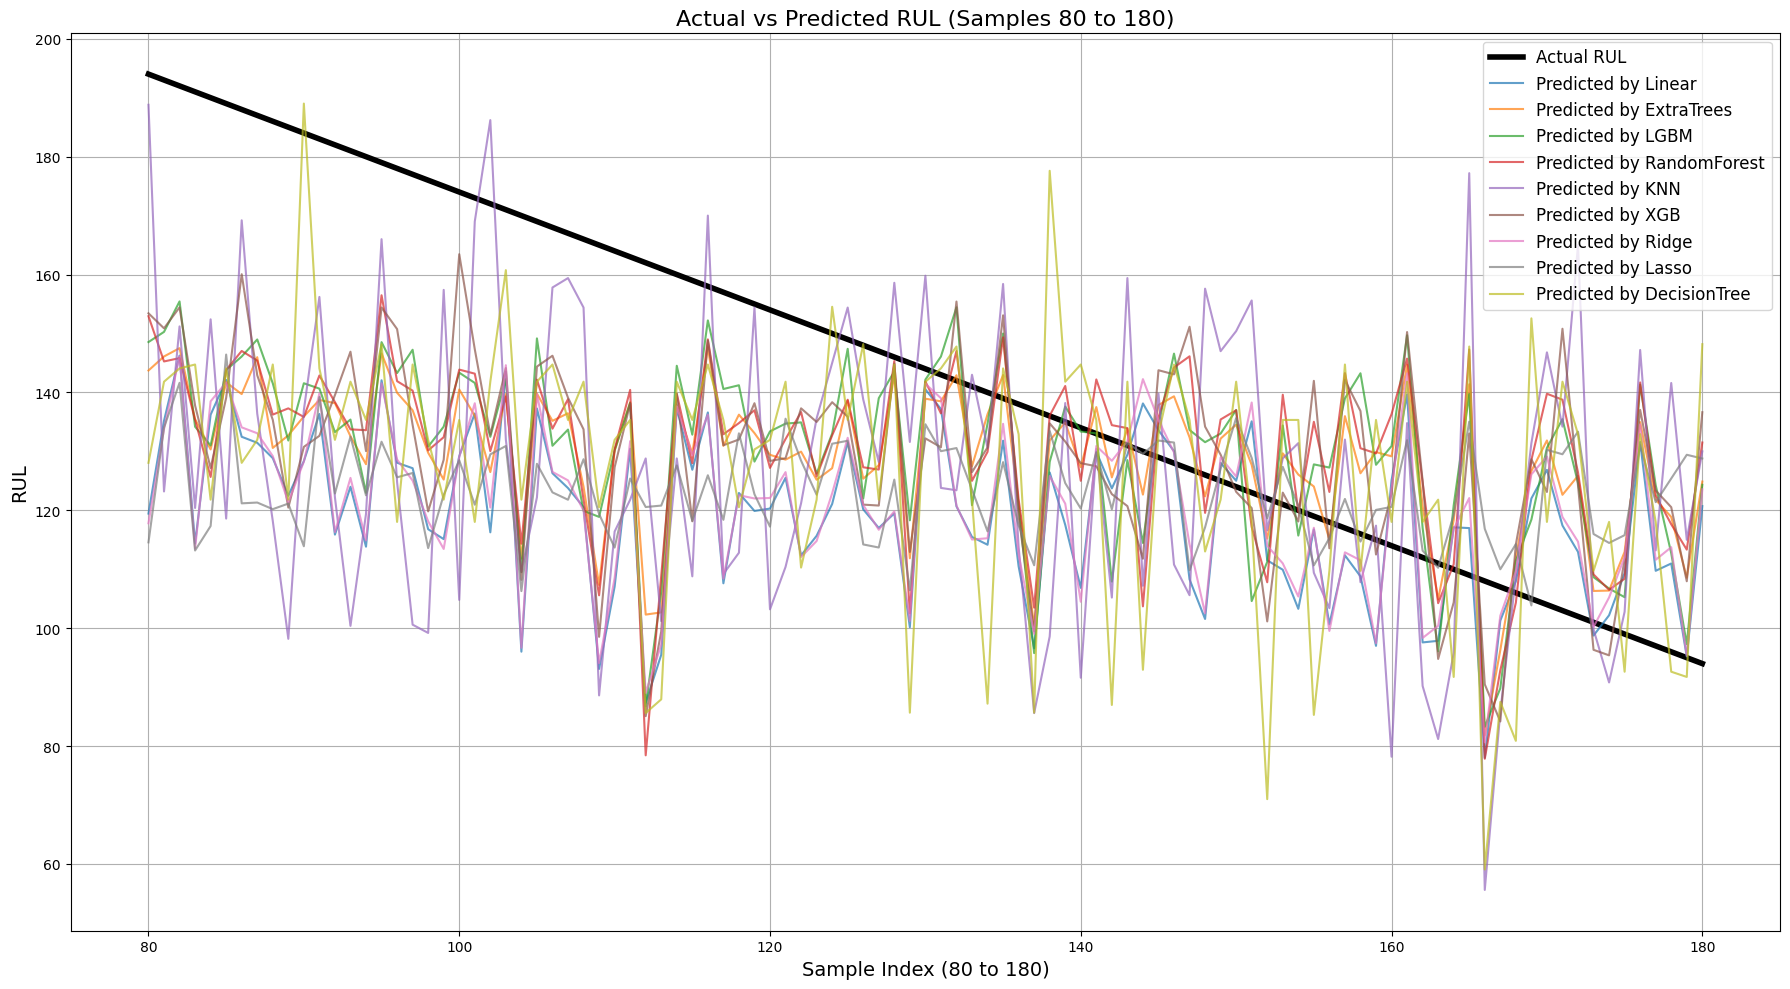

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Create x-axis for samples 80 to 180
x_axis = np.arange(80, 181)

plt.figure(figsize=(18, 10))

# Plot actual RUL for samples 80 to 180
plt.plot(x_axis, y_test[80:181], label='Actual RUL', linewidth=4, color='black')

# Plot predictions from each model for samples 80 to 180
for idx, name in enumerate(model_names[:len(all_preds)]):
    plt.plot(x_axis, all_preds[idx, 80:181], label=f'Predicted by {name}', alpha=0.7)

plt.xlabel('Sample Index (80 to 180)', fontsize=14)
plt.ylabel('RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (Samples 80 to 180)', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


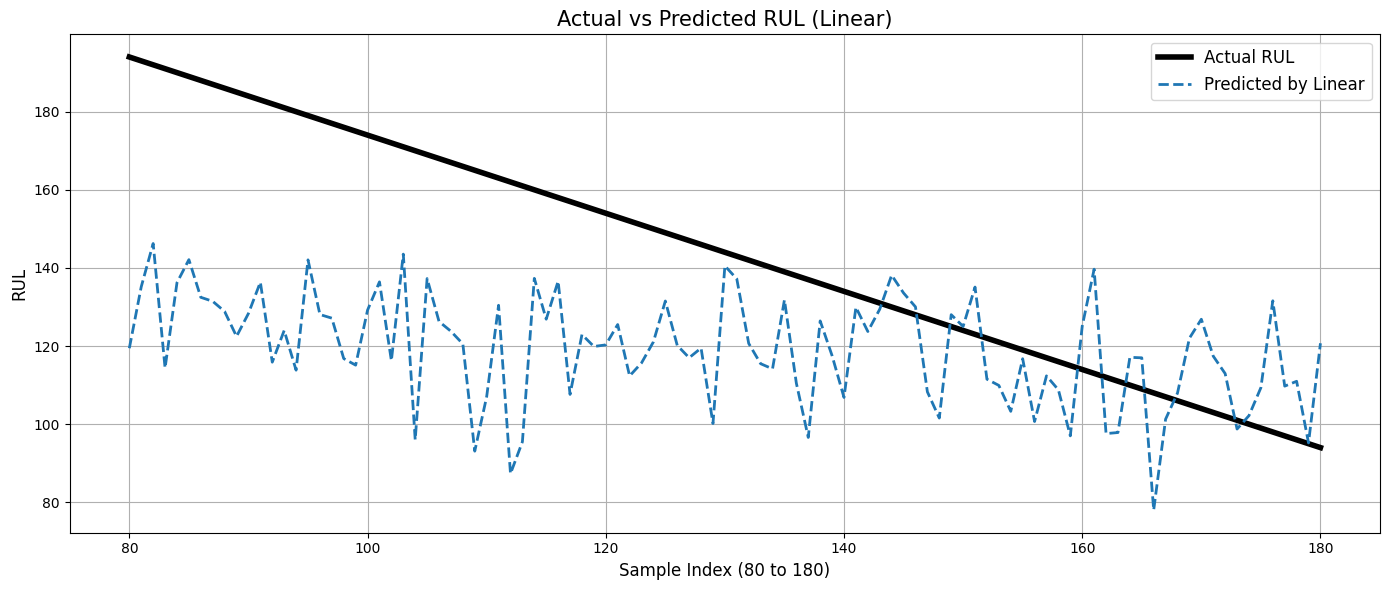

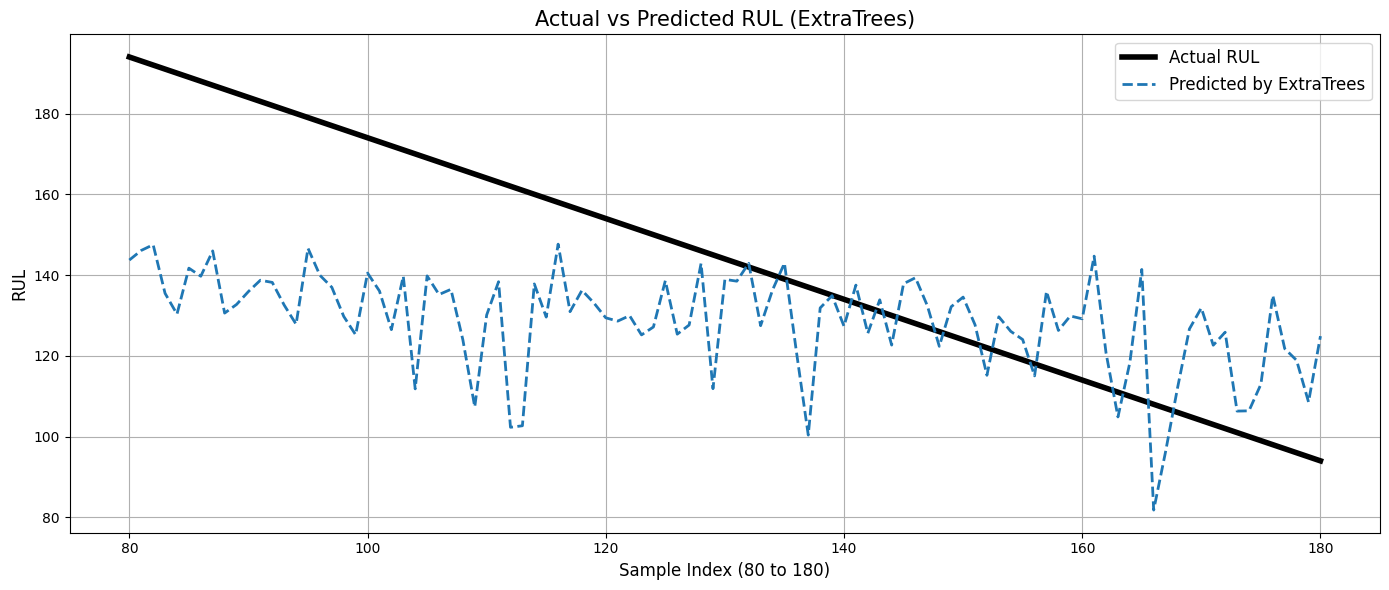

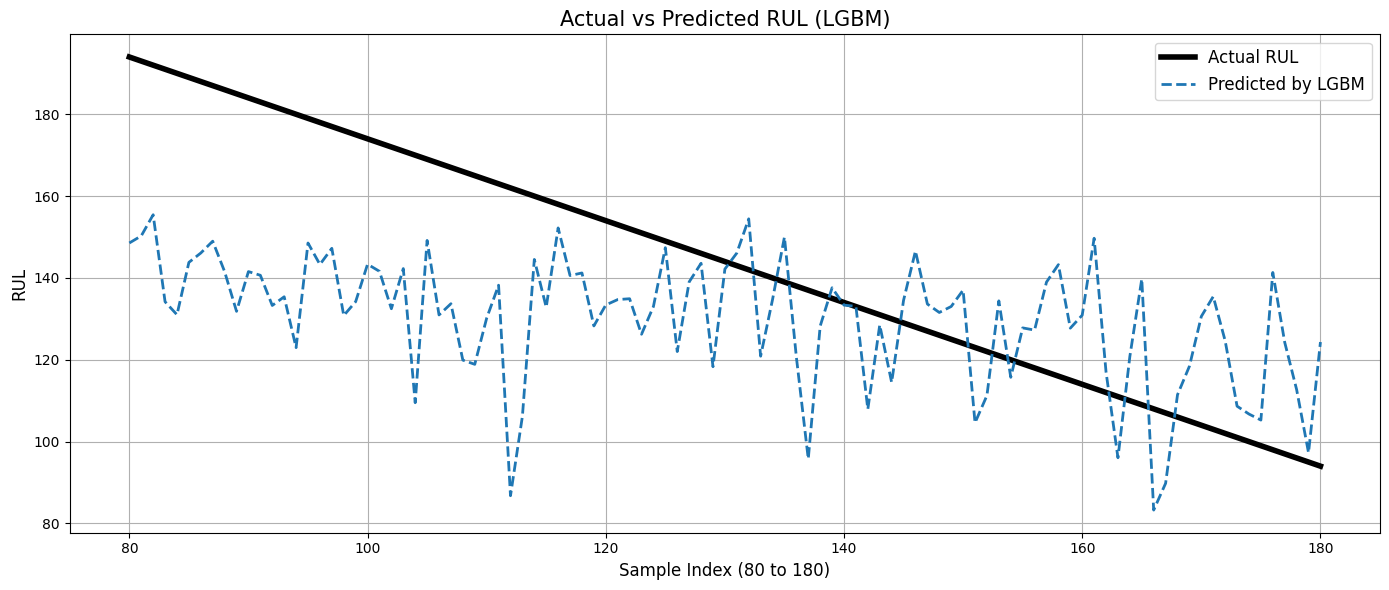

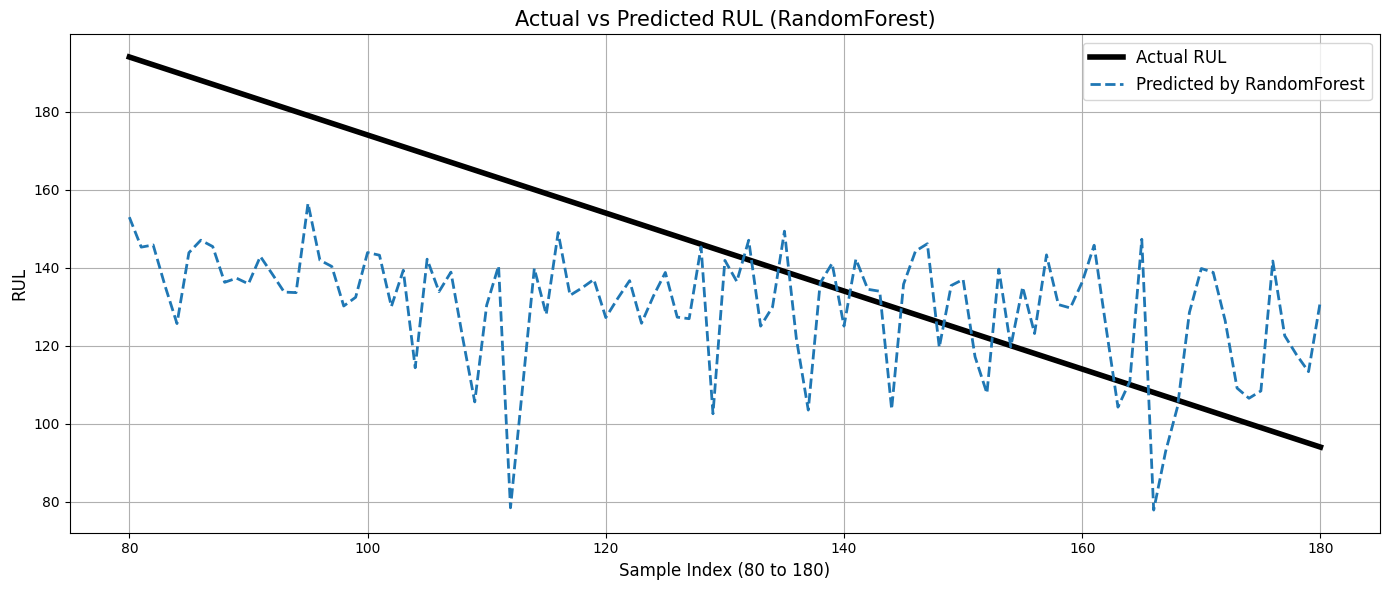

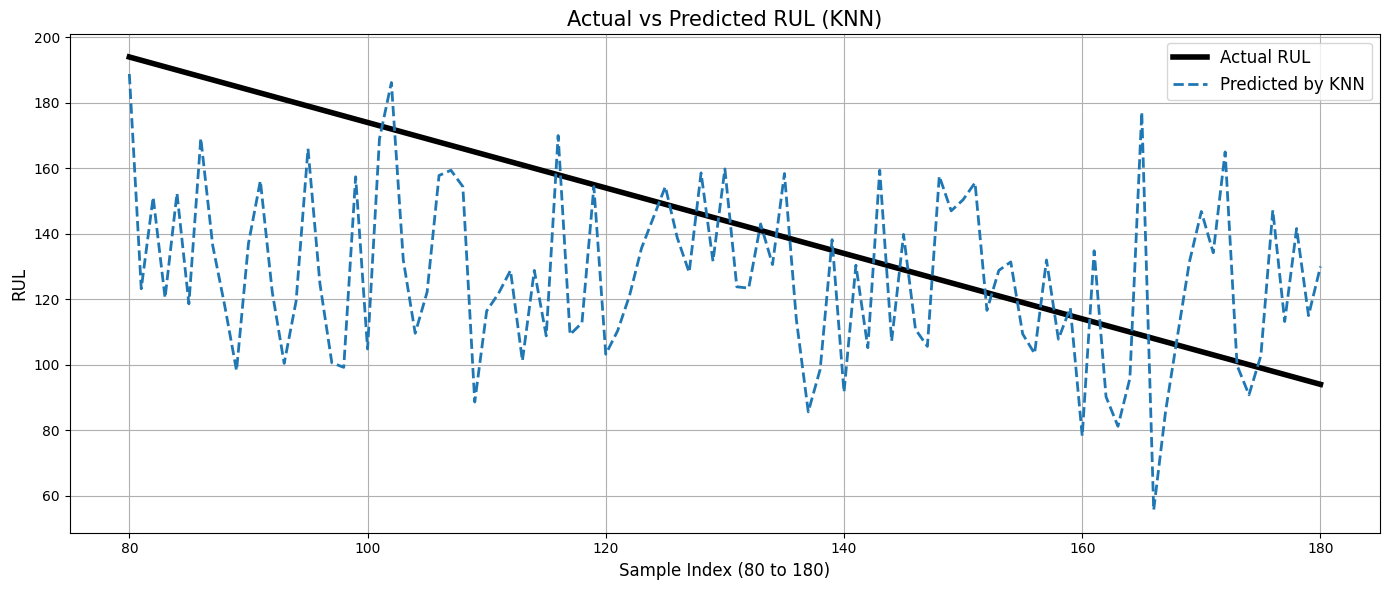

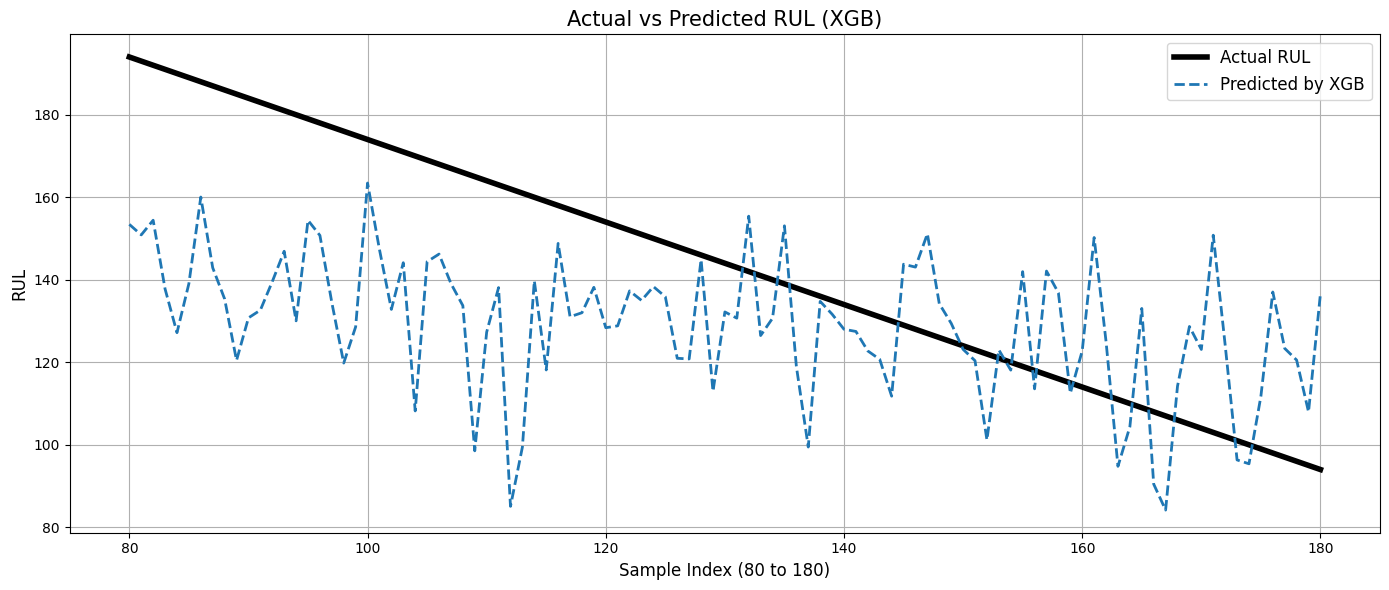

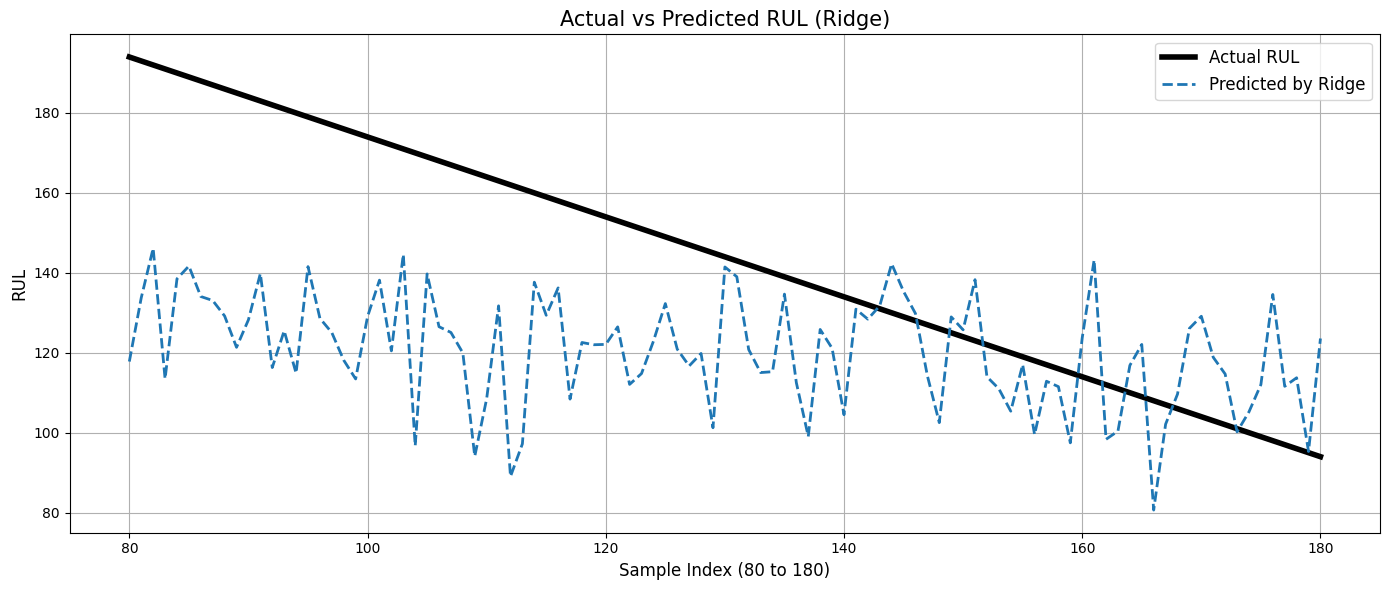

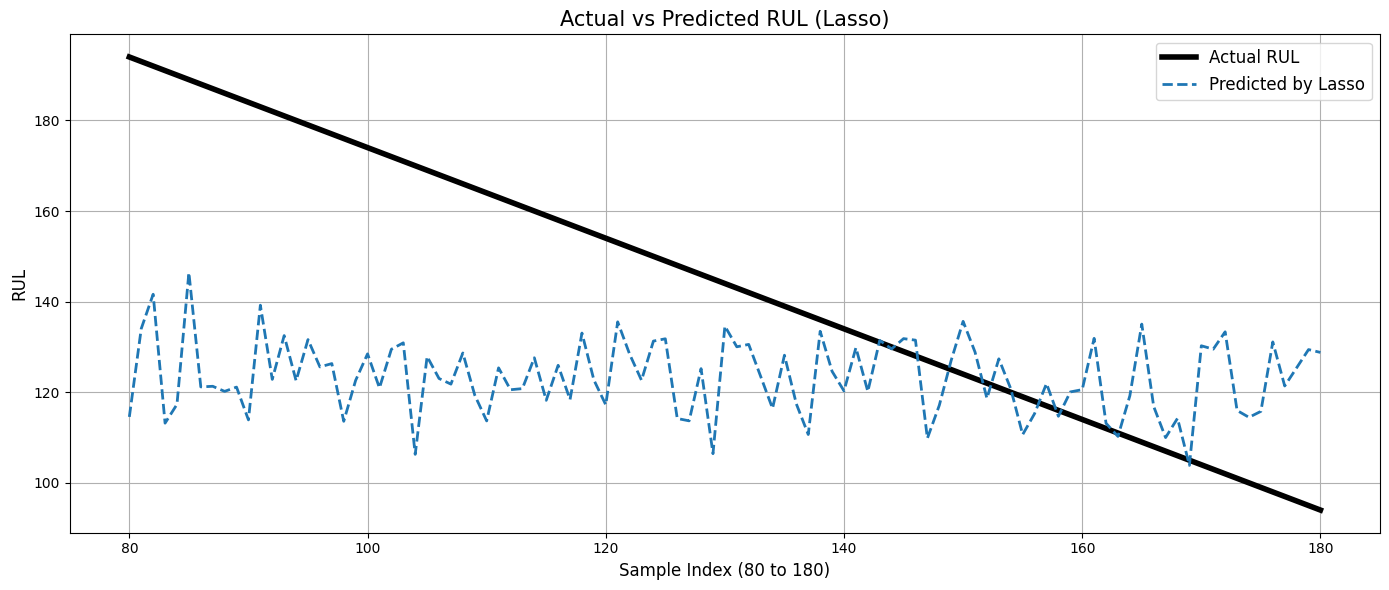

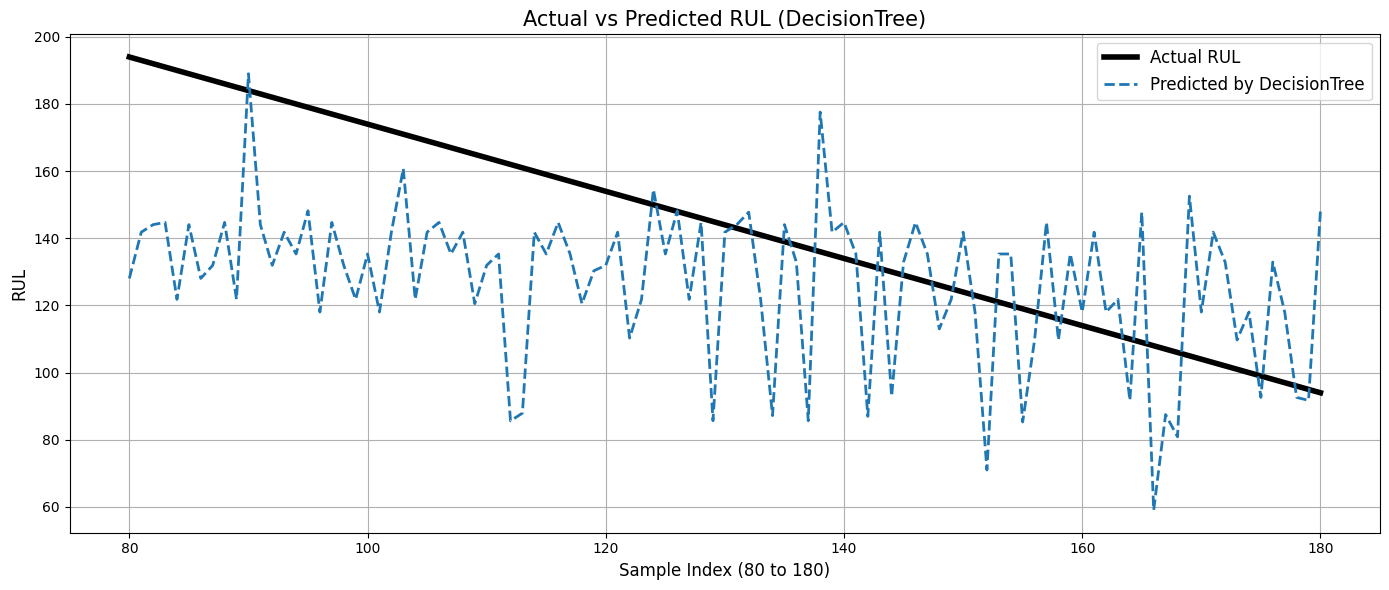

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# Setup for plotting
x_axis = np.arange(80, 181)  # sample 80 to 180
n_models = all_preds.shape[0]

for idx in range(n_models):
    plt.figure(figsize=(14, 6))
    
    # Plot Actual RUL
    plt.plot(x_axis, y_test[80:181], label='Actual RUL', linewidth=4, color='black')
    
    # Plot Predicted RUL for this model
    plt.plot(x_axis, all_preds[idx, 80:181], label=f'Predicted by {model_names[idx]}', linewidth=2, linestyle='--')
    
    plt.xlabel('Sample Index (80 to 180)', fontsize=12)
    plt.ylabel('RUL', fontsize=12)
    plt.title(f'Actual vs Predicted RUL ({model_names[idx]})', fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


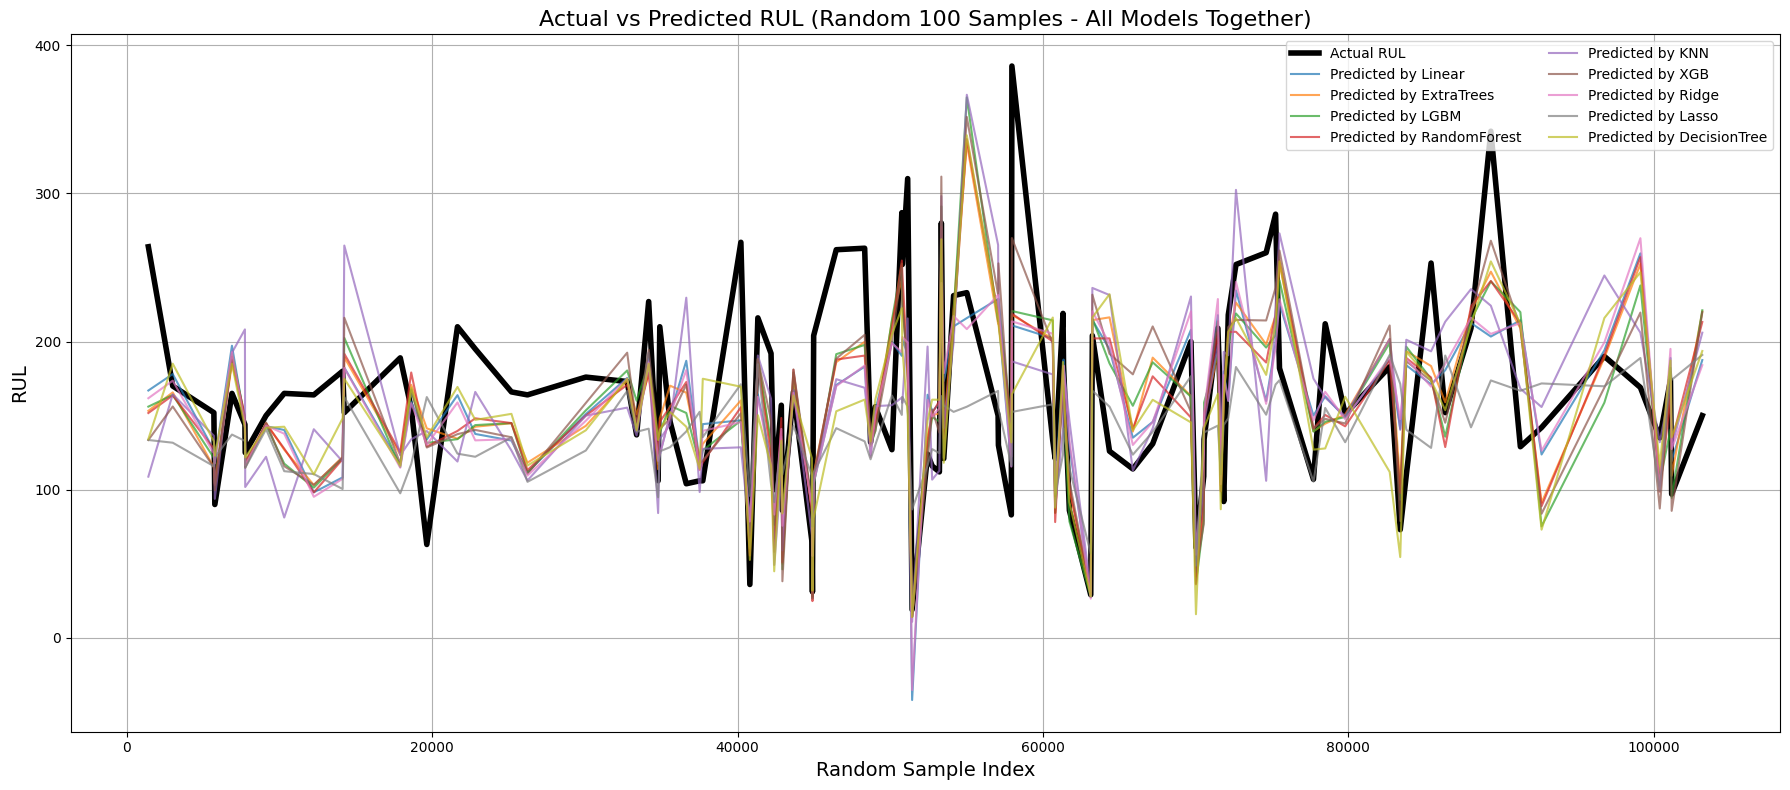

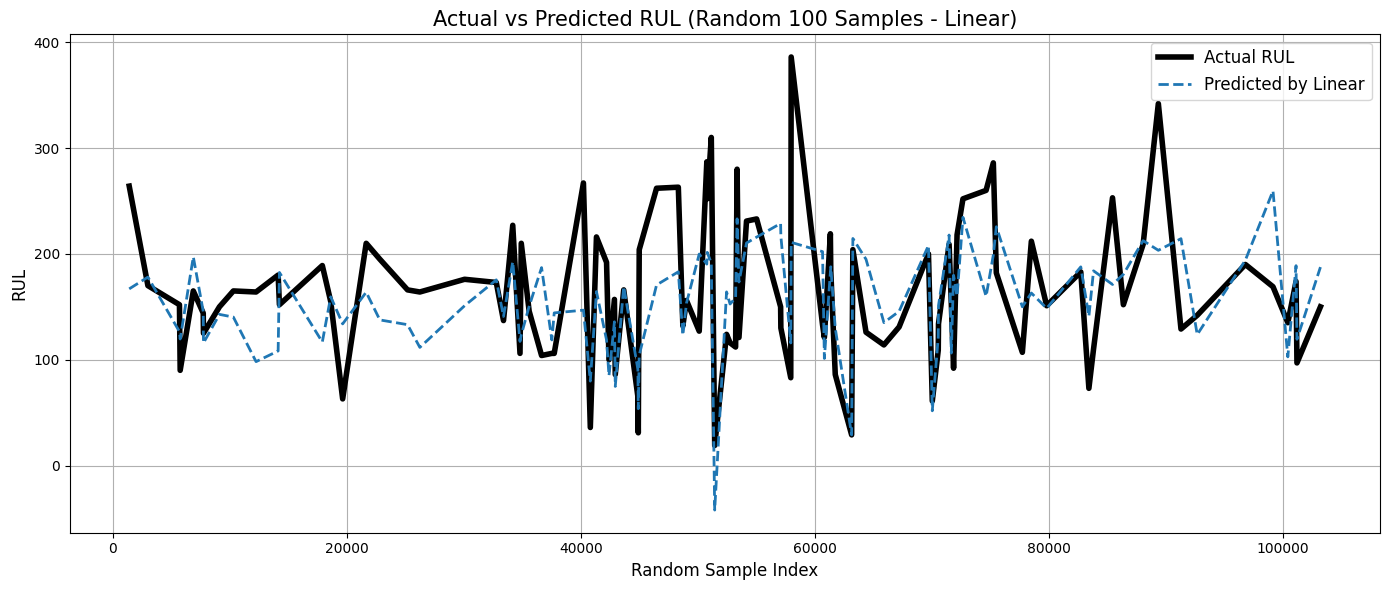

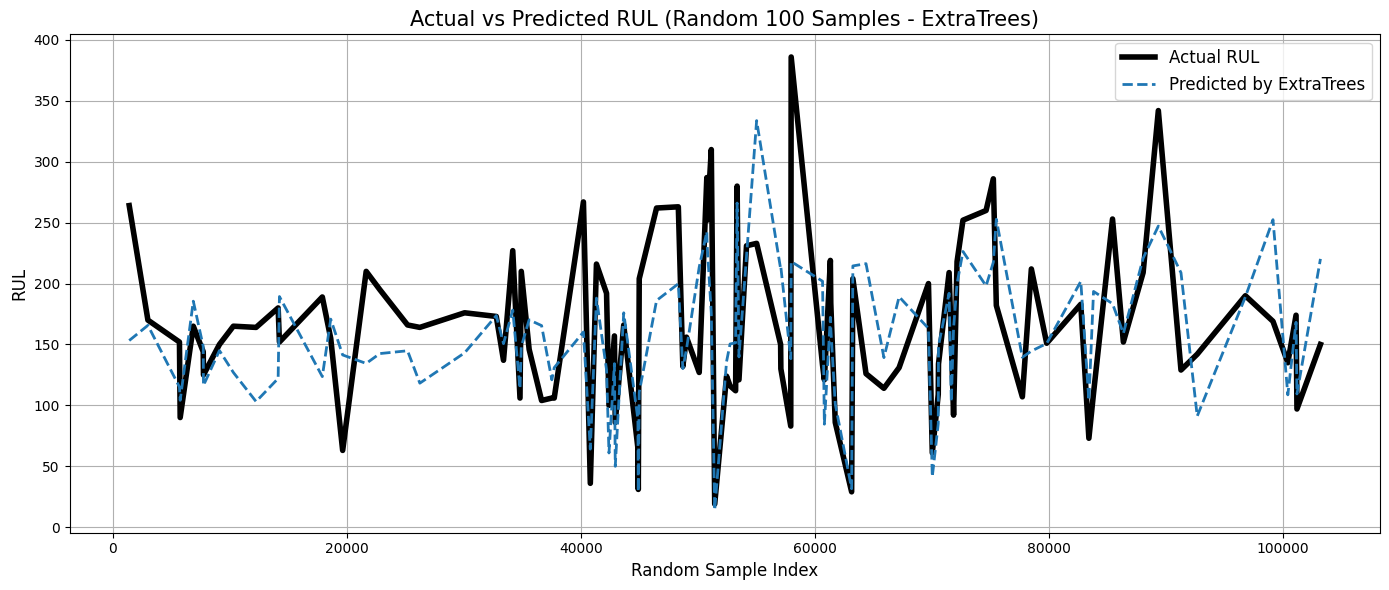

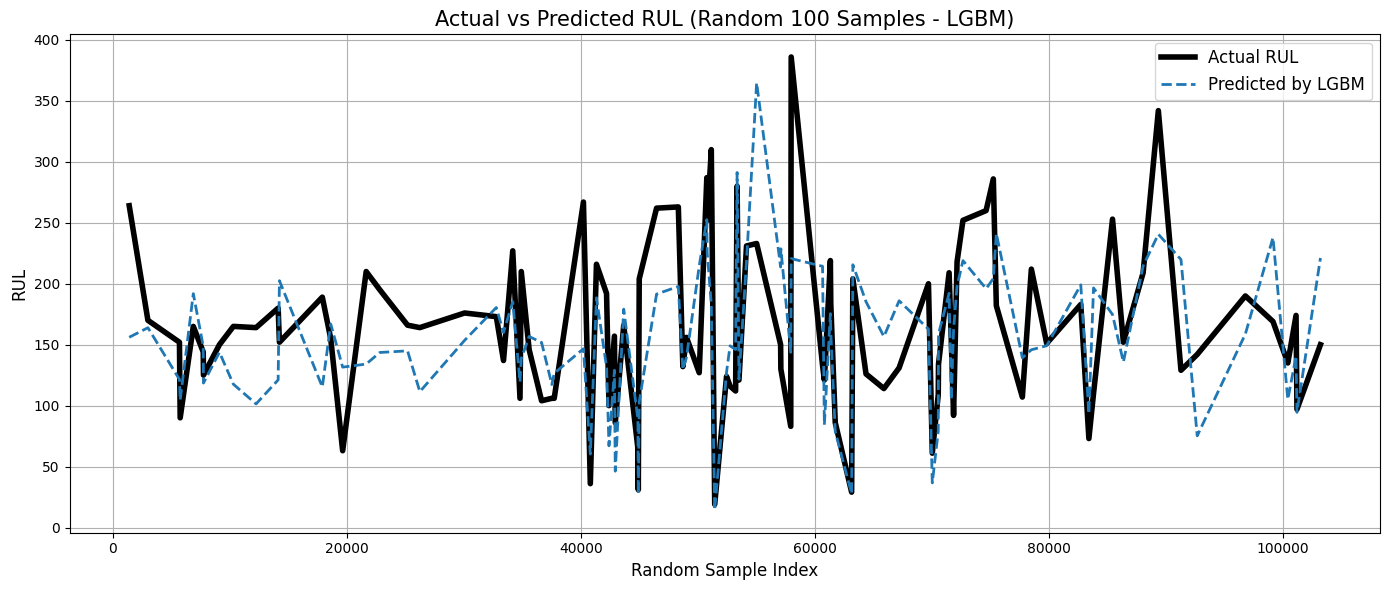

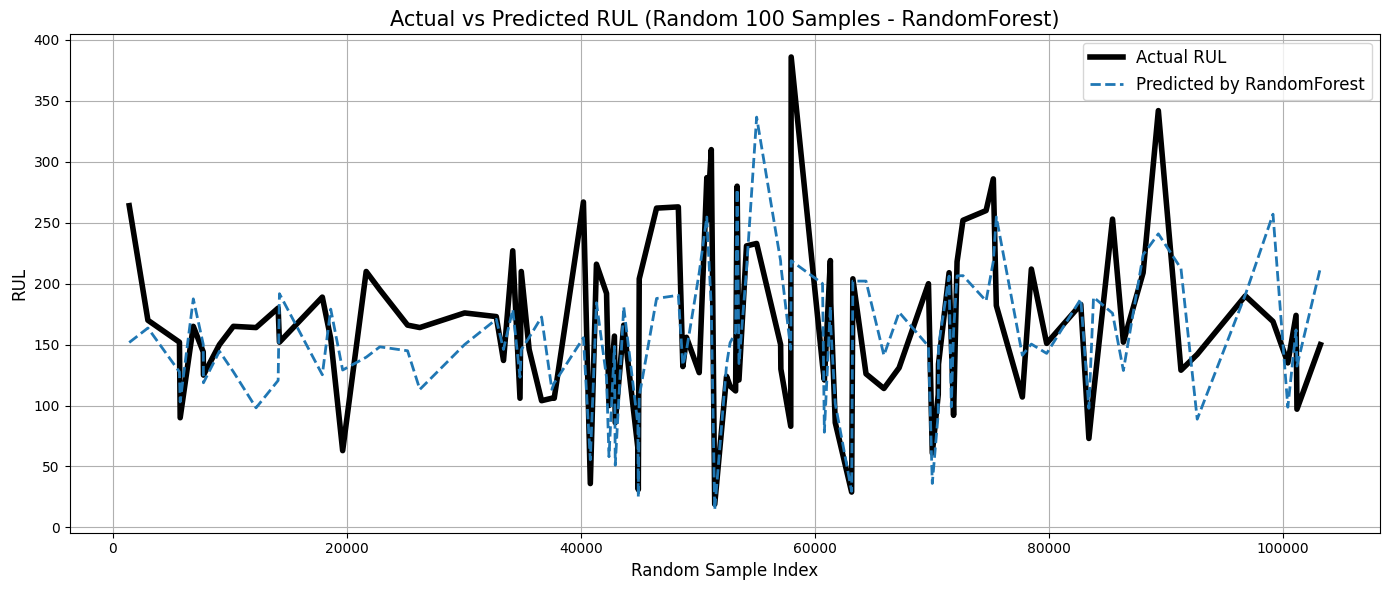

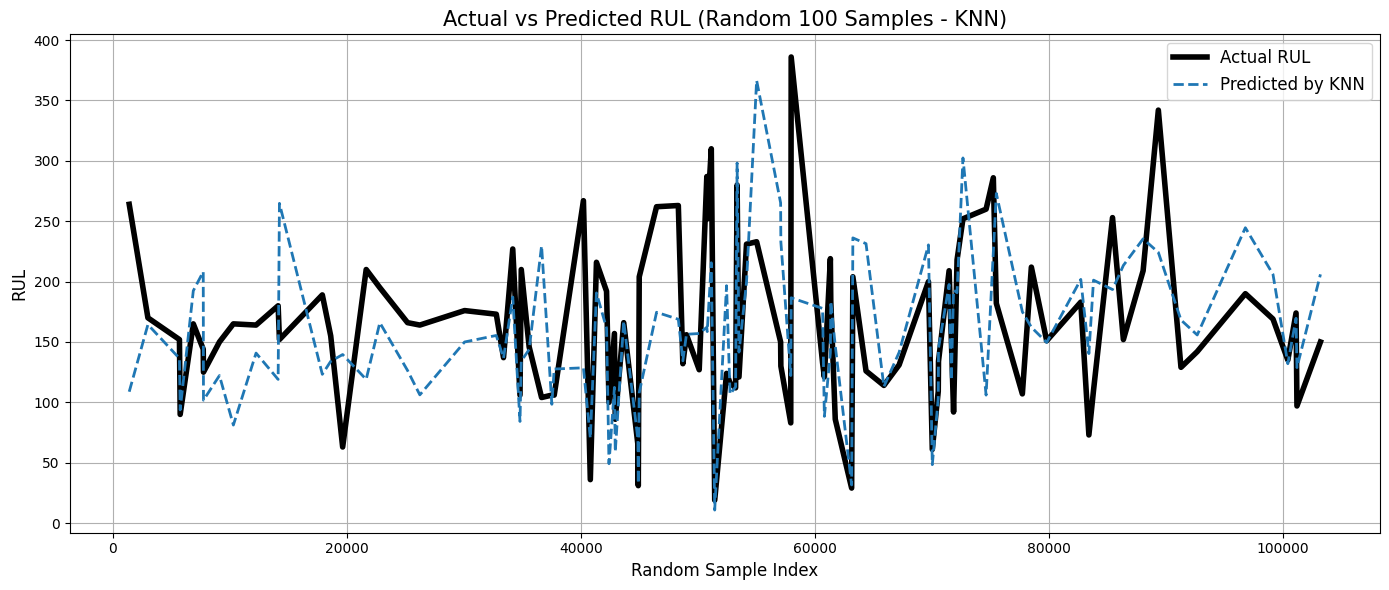

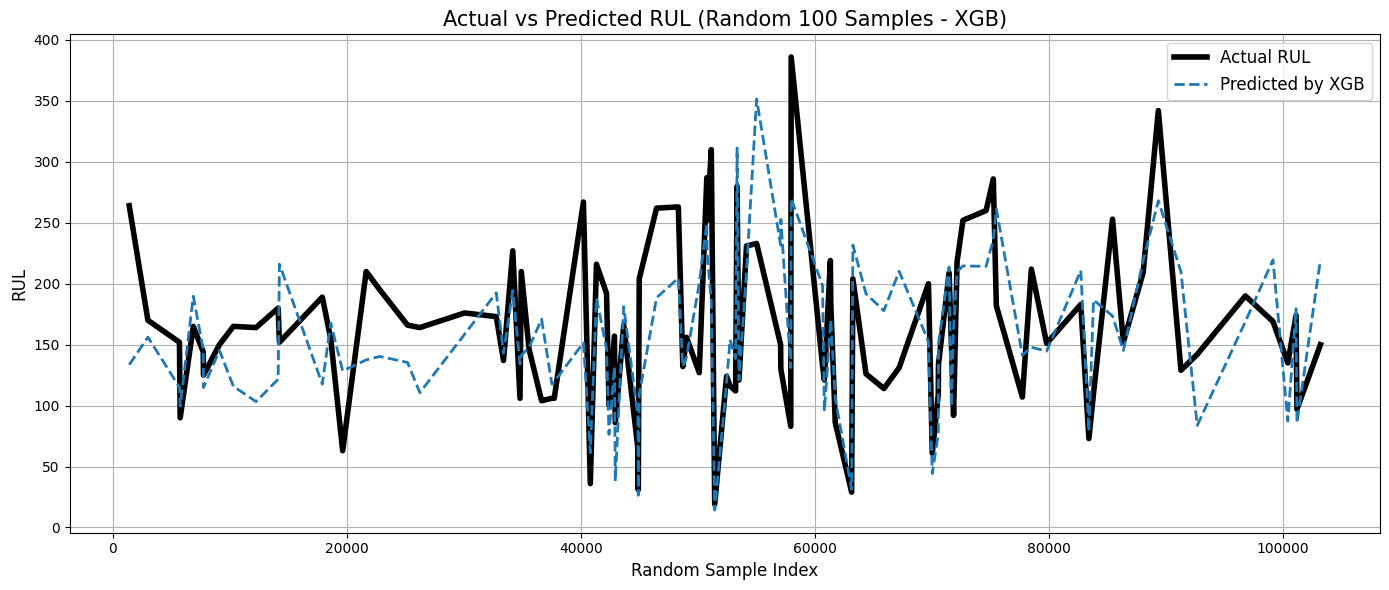

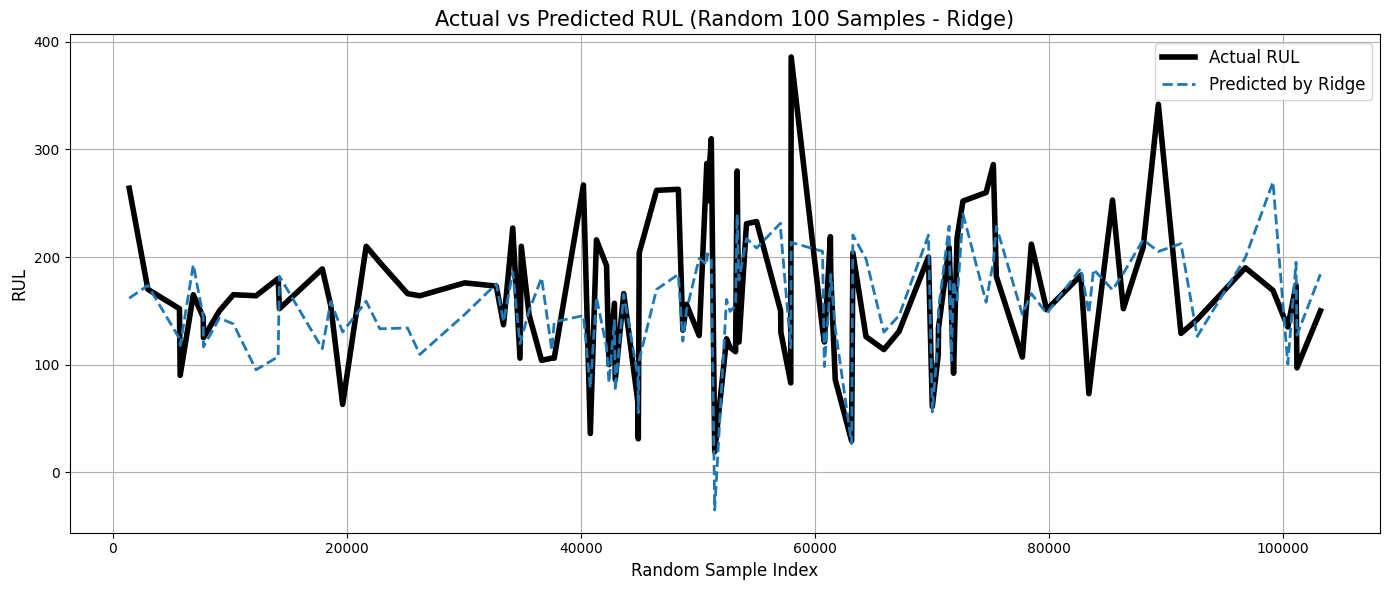

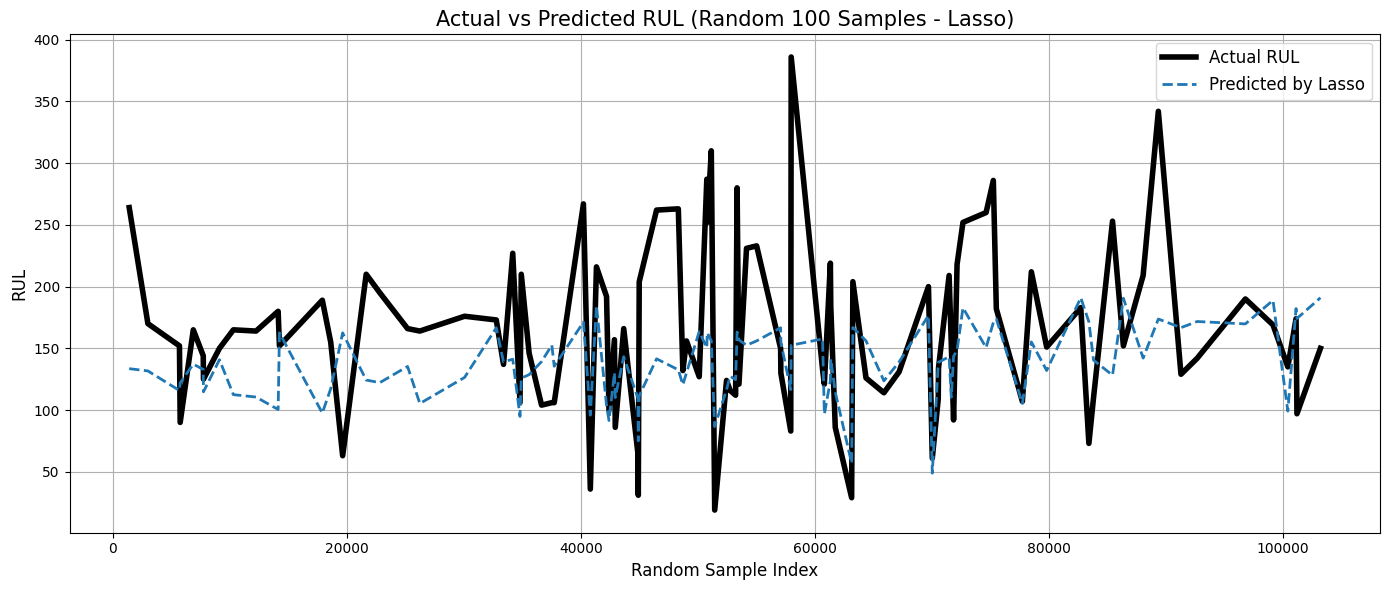

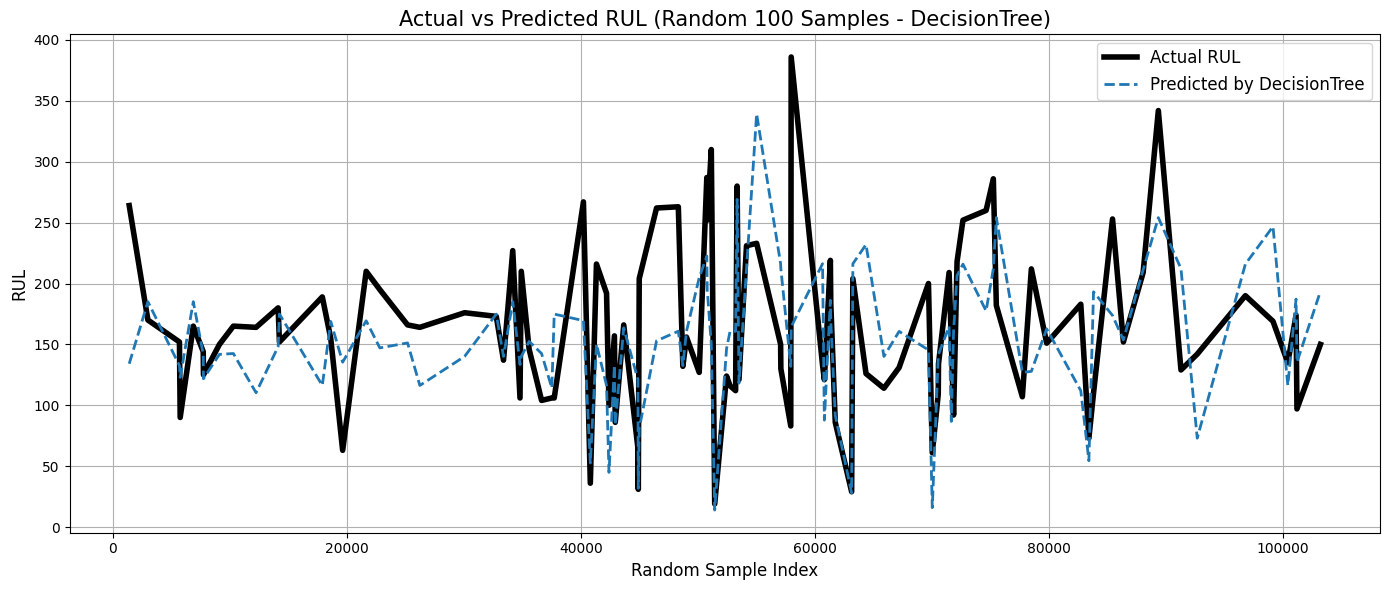

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Step 1: Pick 100 Random Indices =====
np.random.seed(42)  # for reproducibility
random_indices = np.random.choice(len(y_test), size=100, replace=False)
random_indices = np.sort(random_indices)  # optional, makes x-axis neater

x_axis = random_indices  # X-axis will be random sample indices
n_models = all_preds.shape[0]  # No. of models

# ===== Step 2: Plot All Models Together =====
plt.figure(figsize=(18, 8))

# Plot Actual RUL
plt.plot(x_axis, y_test[random_indices], label='Actual RUL', linewidth=4, color='black')

# Plot each model's predictions
for idx in range(n_models):
    plt.plot(x_axis, all_preds[idx, random_indices], label=f'Predicted by {model_names[idx]}', alpha=0.7)

plt.xlabel('Random Sample Index', fontsize=14)
plt.ylabel('RUL', fontsize=14)
plt.title('Actual vs Predicted RUL (Random 100 Samples - All Models Together)', fontsize=16)
plt.legend(fontsize=10, loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Step 3: Plot Each Model Separately =====
for idx in range(n_models):
    plt.figure(figsize=(14, 6))
    
    # Plot Actual RUL
    plt.plot(x_axis, y_test[random_indices], label='Actual RUL', linewidth=4, color='black')
    
    # Plot Predicted RUL for this model
    plt.plot(x_axis, all_preds[idx, random_indices], label=f'Predicted by {model_names[idx]}', linewidth=2, linestyle='--')
    
    plt.xlabel('Random Sample Index', fontsize=12)
    plt.ylabel('RUL', fontsize=12)
    plt.title(f'Actual vs Predicted RUL (Random 100 Samples - {model_names[idx]})', fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


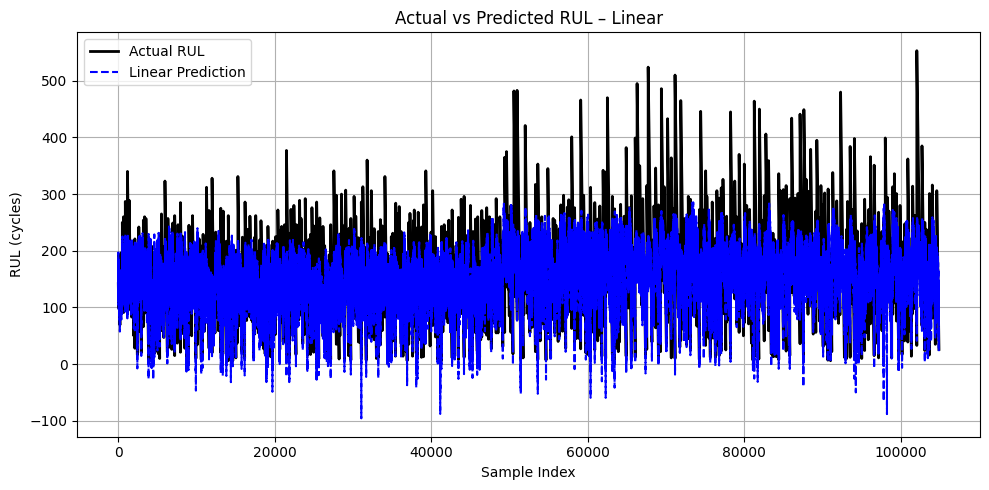

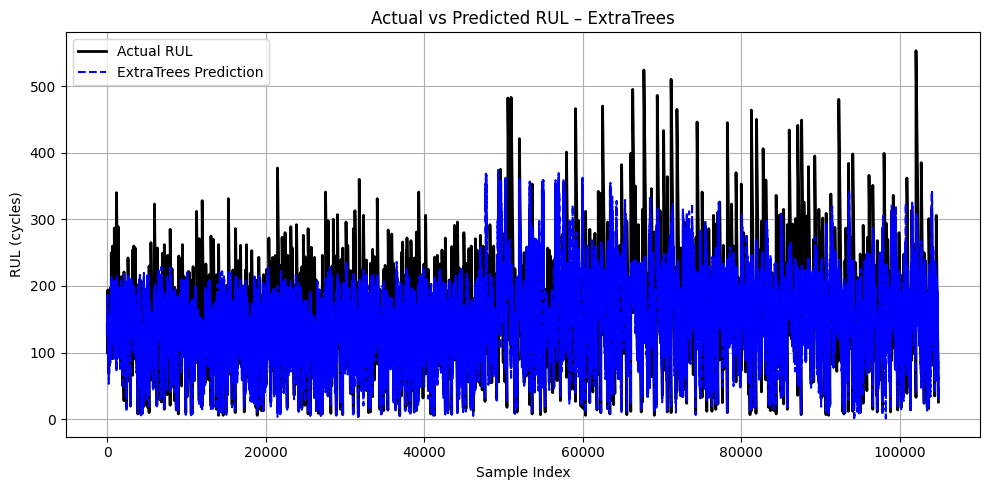

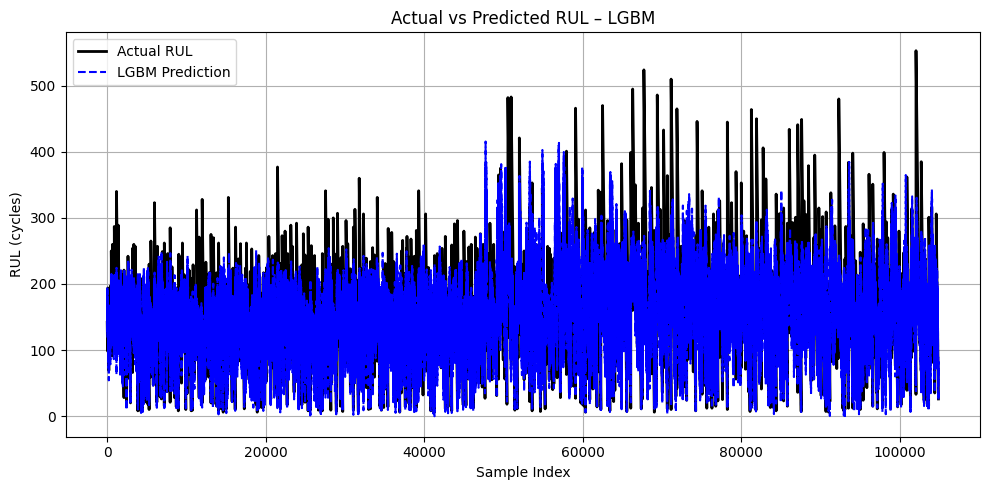

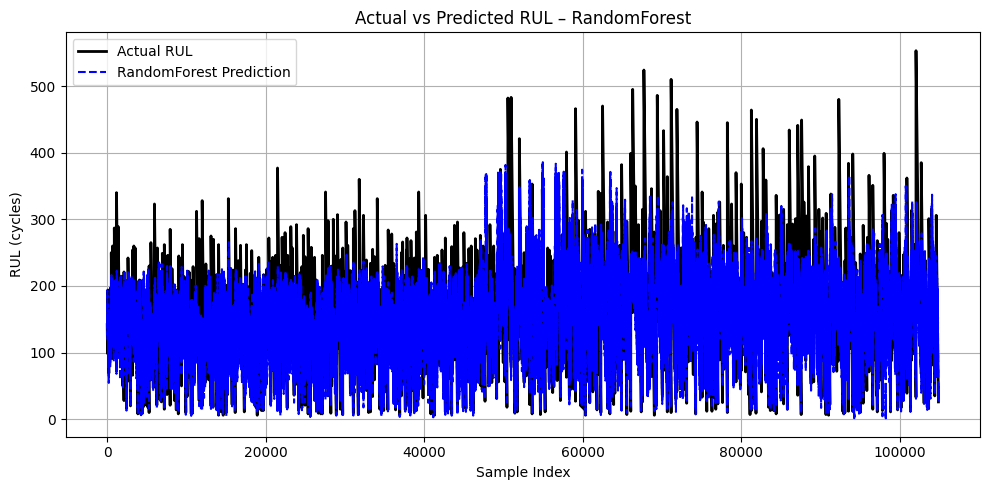

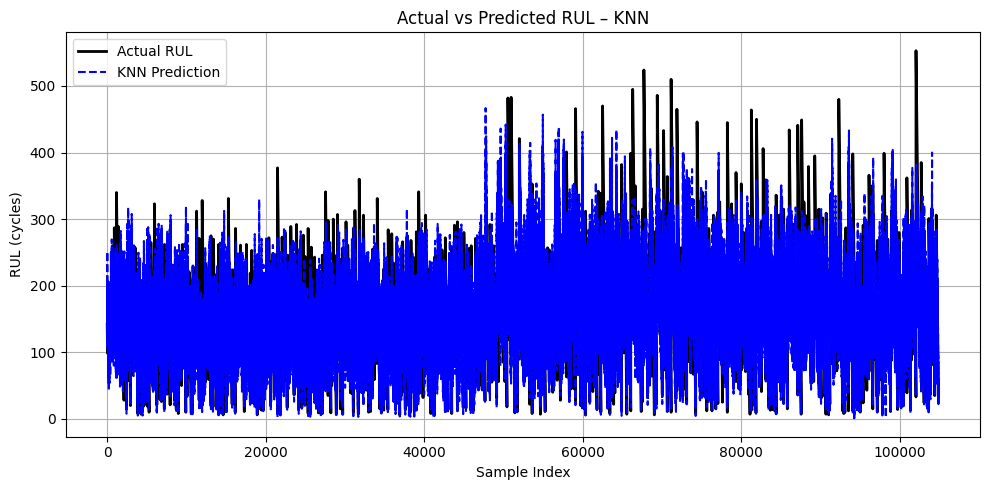

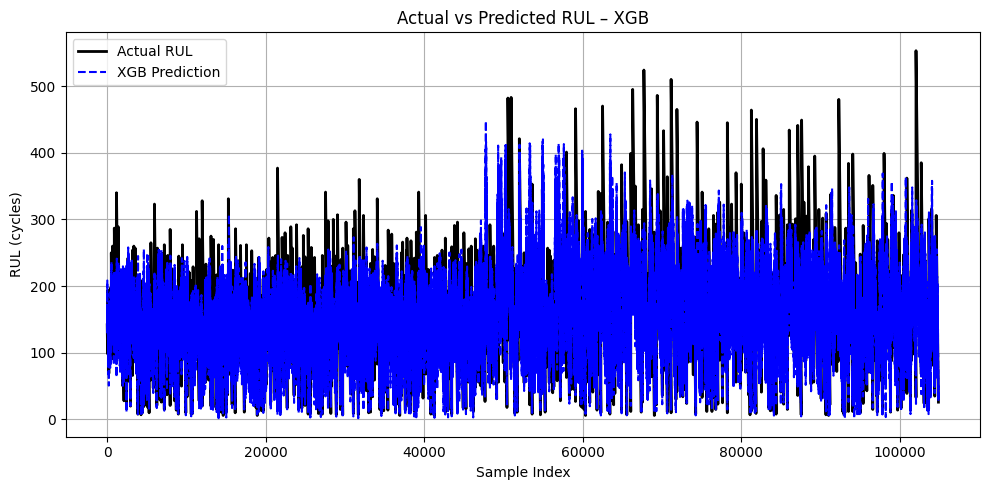

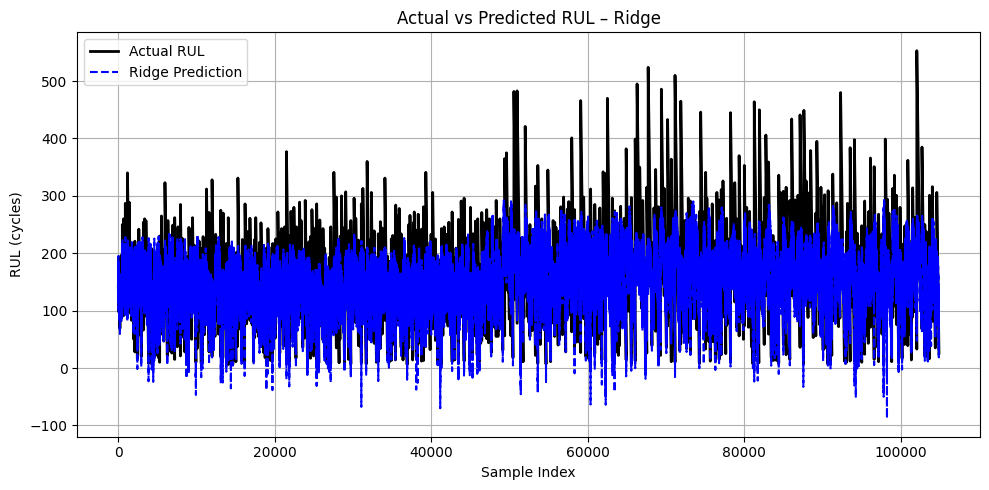

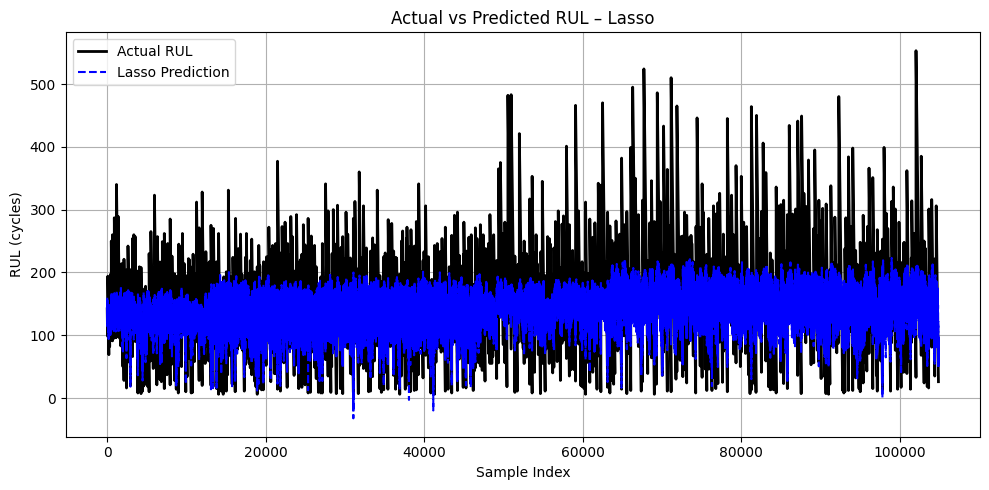

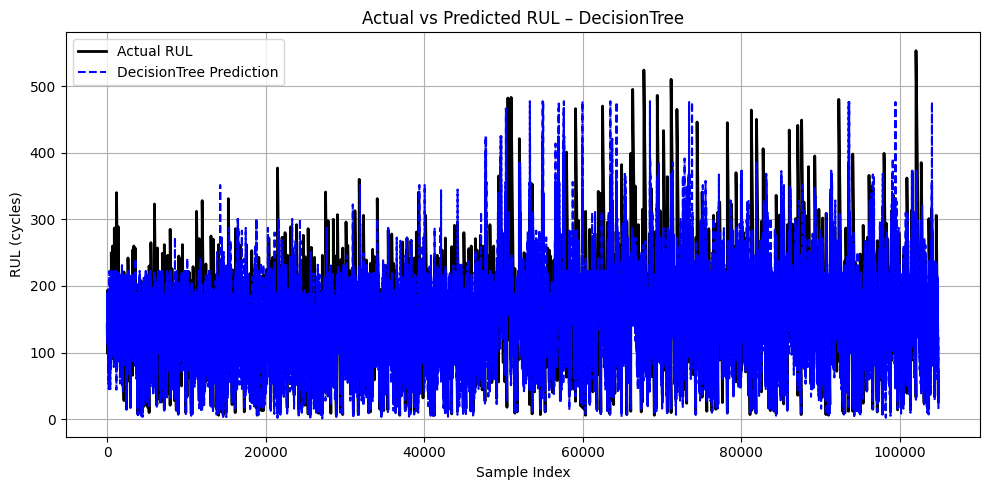

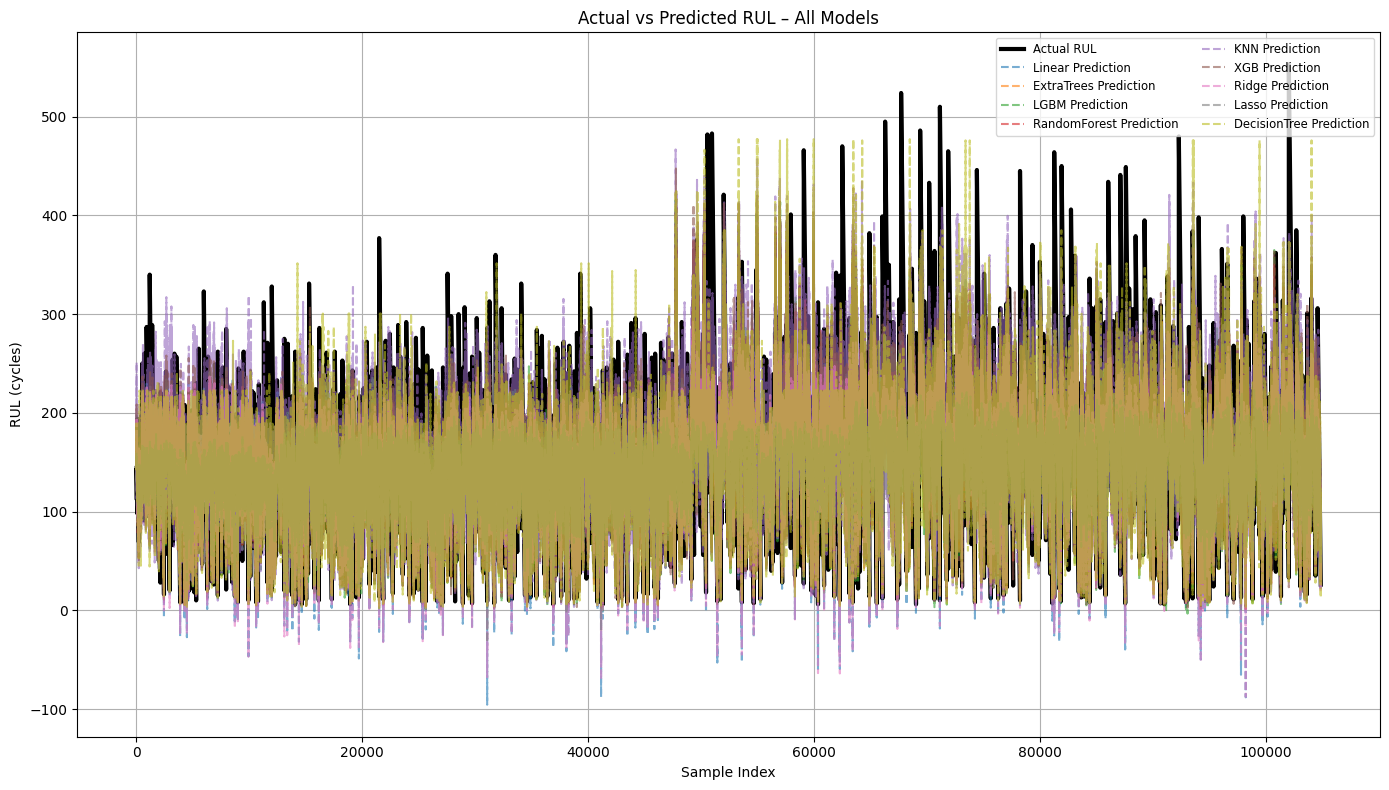

In [174]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure model_names matches all_preds shape
model_names = model_names[:all_preds.shape[0]]

# === Plot predictions for each model separately ===
for i, name in enumerate(model_names):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual RUL', color='black', linewidth=2)
    plt.plot(all_preds[i], label=f'{name} Prediction', color='blue', linestyle='--')
    plt.title(f'Actual vs Predicted RUL – {name}')
    plt.xlabel('Sample Index')
    plt.ylabel('RUL (cycles)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Combined plot of all models ===
plt.figure(figsize=(14, 8))
plt.plot(y_test, label='Actual RUL', color='black', linewidth=3)

for i in range(len(model_names)):
    plt.plot(all_preds[i], label=f'{model_names[i]} Prediction', alpha=0.6, linestyle='--')

plt.title("Actual vs Predicted RUL – All Models")
plt.xlabel("Sample Index")
plt.ylabel("RUL (cycles)")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [175]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Trim model_names to match all_preds ===
n_models = all_preds.shape[0]
model_names = model_names[:n_models]

# === Utility Functions ===
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

def tolerance_accuracy(y_true, y_pred, tolerances):
    return {
        f"Accuracy ±{tol}": np.mean(np.abs(y_true - y_pred) <= tol) * 100
        for tol in tolerances
    }

# === Setup Tolerance Levels ===
tolerances = list(range(10, 101, 10))  # [10, 20, ..., 100]

# === Ensemble Evaluation ===
print("\n🚀 Starting ensemble combination evaluation...")

best_score = float('-inf')
best_combo = None
metrics_log = {}
total_combos = 2 ** n_models - 1
n = len(y_test)

for i in range(1, total_combos + 1):
    bitset = format(i, f'0{n_models}b')
    selected_idxs = [j for j, b in enumerate(bitset) if b == '1']

    # Ensemble prediction
    selected_preds = all_preds[selected_idxs]
    ensemble_pred = np.mean(selected_preds, axis=0)

    # Metrics
    mse = mean_squared_error(y_test, ensemble_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, ensemble_pred)
    r2 = r2_score(y_test, ensemble_pred)
    k = len(selected_idxs)
    adj_r2 = adjusted_r2(r2, n, k)
    accs = tolerance_accuracy(y_test, ensemble_pred, tolerances)

    # Save best
    if r2 > best_score:
        best_score = r2
        best_combo = bitset
        metrics_log[bitset] = {
            "models": [model_names[j] for j in selected_idxs],
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "Adjusted R2": adj_r2,
            **accs
        }

    if i % 100 == 0 or i == total_combos:
        print(f"[{i}/{total_combos}] ✔ Bitset: {bitset} | R²: {r2:.4f} | Best R²: {best_score:.4f}")

# === Final Output ===
print("\n✅ Finished evaluating all combinations.")
print(f"🏆 Best Ensemble Bitset: {best_combo}")
print(f"📦 Best Models: {metrics_log[best_combo]['models']}")
print(f"📉 MSE: {metrics_log[best_combo]['MSE']:.4f}")
print(f"📏 RMSE: {metrics_log[best_combo]['RMSE']:.4f}")
print(f"📊 MAE: {metrics_log[best_combo]['MAE']:.4f}")
print(f"📈 R²: {metrics_log[best_combo]['R2']:.4f}")
print(f"🧮 Adjusted R²: {metrics_log[best_combo]['Adjusted R2']:.4f}")
for tol in tolerances:
    print(f"🎯 Accuracy within ±{tol} cycles: {metrics_log[best_combo][f'Accuracy ±{tol}']:.2f}%")



🚀 Starting ensemble combination evaluation...
[100/511] ✔ Bitset: 001100100 | R²: 0.4139 | Best R²: 0.4188
[200/511] ✔ Bitset: 011001000 | R²: 0.4186 | Best R²: 0.4196
[300/511] ✔ Bitset: 100101100 | R²: 0.4038 | Best R²: 0.4203
[400/511] ✔ Bitset: 110010000 | R²: 0.3883 | Best R²: 0.4203
[500/511] ✔ Bitset: 111110100 | R²: 0.4062 | Best R²: 0.4203
[511/511] ✔ Bitset: 111111111 | R²: 0.4009 | Best R²: 0.4203

✅ Finished evaluating all combinations.
🏆 Best Ensemble Bitset: 011100000
📦 Best Models: ['ExtraTrees', 'LGBM', 'RandomForest']
📉 MSE: 3791.8530
📏 RMSE: 61.5780
📊 MAE: 44.9988
📈 R²: 0.4203
🧮 Adjusted R²: 0.4202
🎯 Accuracy within ±10 cycles: 17.43%
🎯 Accuracy within ±20 cycles: 32.63%
🎯 Accuracy within ±30 cycles: 45.76%
🎯 Accuracy within ±40 cycles: 56.76%
🎯 Accuracy within ±50 cycles: 65.99%
🎯 Accuracy within ±60 cycles: 73.52%
🎯 Accuracy within ±70 cycles: 79.57%
🎯 Accuracy within ±80 cycles: 84.31%
🎯 Accuracy within ±90 cycles: 88.01%
🎯 Accuracy within ±100 cycles: 90.77%


In [176]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Setup ===
n_models = all_preds.shape[0]
model_names = model_names[:n_models]
n = len(y_test)

# === Helper Function ===
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# === Collect Metrics for Each Model ===
rows = []

for i in range(n_models):
    y_pred = all_preds[i]
    r2 = r2_score(y_test, y_pred)
    k = 1  # One model

    row = {
        "Model": model_names[i],
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2,
        "Adjusted R2": adjusted_r2(r2, n, k)
    }
    rows.append(row)

# === Create and Display DataFrame ===
df_summary = pd.DataFrame(rows)
df_summary = df_summary.round(4)

# Print clean table
print("\n📊 10-Model Evaluation Metrics Table:\n")
print(df_summary.to_string(index=False))



📊 10-Model Evaluation Metrics Table:

       Model       MSE    RMSE     MAE     R2  Adjusted R2
      Linear 4290.4422 65.5015 48.3662 0.3440       0.3440
  ExtraTrees 3812.8485 61.7483 45.0536 0.4170       0.4170
        LGBM 3834.5923 61.9241 45.3251 0.4137       0.4137
RandomForest 3828.0381 61.8711 45.2930 0.4147       0.4147
         KNN 4719.6243 68.6995 50.6420 0.2784       0.2784
         XGB 3914.2896 62.5643 45.8709 0.4015       0.4015
       Ridge 4318.5552 65.7157 48.6213 0.3397       0.3397
       Lasso 5835.6235 76.3913 56.0819 0.1078       0.1078
DecisionTree 4304.7333 65.6105 48.1315 0.3418       0.3418
